In [15]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time

num_cores = 32

%run initMethods.py
%run makeGif.py
%run methods.py

In [16]:
params = { #parameters relevant for the equations
    "Nh":           10000,
    "N0":            1000,
    "R0":               5,
    "M":                1, #Also L, total number of spacers
    "D":                3, #Unused
    "mu":            0.02, #mutation rate
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":             1000, #cross-reactivity kernel
    "rho":           5e-5, #spacer sharing coeff
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                 1000,
    "dx":                         1,
    "t0":                         0, 
    "tf":                       100,
    "dt":                         1,
    "initial_mean":           [0,0],
    "initial_var":                5,
    "n_step_prior":               5,
    "conv_size":               1000,
}

In [17]:
n = init_guassian(params["N0"], sim_params)
nh = init_guassian(params["Nh"], sim_params)
kernel = init_kernel(params, sim_params)

In [18]:
def growth_calc(n_split, nh_split, params, sim_params):
    if np.sum(n_split) > 0:
        p_split = coverage_convolution(nh_split, kernel, params, sim_params)
        f_split = fitness_spacers(n_split, nh_split, p_split, params, sim_params)
        n_split = virus_growth(n_split, f_split, params, sim_params)
    return n_split

def immunity_calc(nh_split, n_split, params, sim_params):
    
    nh_split = immunity_gain(nh_split, n_split, params, sim_params)
    nh_split = immunity_loss(nh_split, n_split, params, sim_params)
    return nh_split

In [19]:
# R0_sweep = np.exp(np.linspace(0, 1, 20))
R0_sweep = [1]
exit_time = []

for R0 in R0_sweep:
    params["R0"] = R0
    n = init_guassian(params["N0"], sim_params)
    nh = init_guassian(params["Nh"], sim_params)

    for i in range(1000):
        st1 = time.time()
        p = coverage_parrallel_convolution(nh, kernel, params, sim_params)

        st2 = time.time()
        f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
        n = virus_growth(n, f, params, sim_params) #update
        n = mutation(n, params, sim_params)

        nh = immunity_update(nh, n, params, sim_params) #update nh
        st3 = time.time()

        et1 = time.strftime("%H:%M:%S", time.gmtime(st2 - st1))
        et2 = time.strftime("%H:%M:%S", time.gmtime(st3 - st2))

        if np.sum(n) >= params["Nh"]:
            exit_time.append(i)
            break

        print("Convolution Time:", et1, "| Update Time:", et2, "| Number of Phage:", np.sum(n))
    else:
        exit_time.append(1000)

else:
    np.save("times.npy", np.array(exit_time).squeeze())
        
    # np.save(f"frame_n{i}.npy", n)
    # np.save(f"frame_nh{i}.npy", nh)

# plt.imshow(n)
# plt.imshow(nh)

In [8]:
input_data = nh/params["Nh"]

def convolve_subset(input_data_subset):
    return scipy.signal.convolve2d(input_data_subset, kernel, mode='same')

input_data_subsets = np.array_split(input_data, num_cores, axis = 0)

results = Parallel(n_jobs=num_cores)(delayed(convolve_subset)(subset) for subset in input_data_subsets)

output_data = np.concatenate(results, axis = 0)

KeyboardInterrupt: 

In [146]:
n_subsets = np.array_split(n, num_cores, axis = 0)
nh_subsets = np.array_split(nh, num_cores, axis= 0)

In [151]:
n_subsets = Parallel(n_jobs=num_cores)(delayed(growth_calc)(n_split, nh_split, params, sim_params) for n_split, nh_split in zip(n_subsets, nh_subsets))
# nh_subsets = Parallel(n_jobs=num_cores)(delayed(immunity_calc)(n_split, nh_split, params, sim_params) for n_split, nh_split in zip(n_subsets, nh_subsets))

In [139]:
n = np.concatenate(n_subsets, axis=0)
nh = np.concatenate(nh_subsets, axis=0)

In [150]:

growth_calc(n, nh, params, sim_params)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

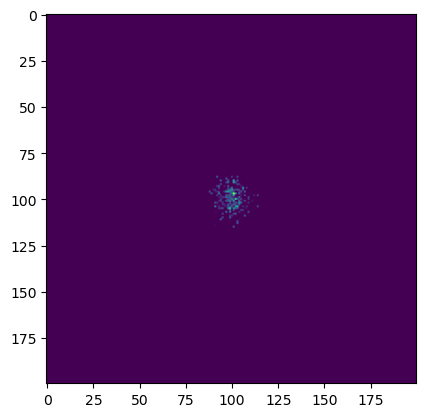

In [142]:
plt.imshow(nh)

In [144]:
np.sum(nh)

3099

In [13]:
# f = fitness_spacers_controlled(n, nh, params, sim_params)
kernel = init_kernel(params, sim_params)
input_data = nh

In [14]:
from joblib import Parallel, delayed

num_cores = 32

def convolve_subset(input_data_subset):
    return scipy.signal.convolve2d(input_data_subset, kernel, mode='same'), 'test'

input_data_subsets = np.array_split(input_data, num_cores, axis = 0)

results = Parallel(n_jobs=num_cores)(delayed(convolve_subset)(subset) for subset in input_data_subsets)

output_data = np.concatenate(results, axis = 0)

In [163]:
nh_temp = nh+n
non_zero_ind = np.where(nh_temp)
nh_temp.shape

(200, 200)

In [59]:
from joblib import Parallel, delayed

num_cores = 16

def convolve_subset(input_data_subset):
    return scipy.signal.convolve2d(input_data_subset, kernel, mode='same')

input_data_subsets = np.array_split(input_data, num_cores, axis = 0)

results = Parallel(n_jobs=num_cores)(delayed(convolve_subset)(subset) for subset in input_data_subsets)

output_data = np.concatenate(results, axis = 0)

KeyboardInterrupt: 

In [51]:
def update_by_section(n, nh, params, sim_params):
    

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])